In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

seed = 7
np.random.seed(seed)

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataset = pd.read_csv('../datasets/pima-indians-diabetes.data.csv', names = names)

X = dataset.values[:,0:8]
Y = dataset.values[:,8]

In [3]:
dataset.head()

,preg,plas,pres,skin,test,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
# create model
model = Sequential()
model.add(Dense(12, input_dim = 8, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(8, kernel_initializer = 'uniform' , activation = 'relu'))
model.add(Dense(1, kernel_initializer = 'uniform' , activation = 'sigmoid'))

In [5]:
# Compile model
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [6]:
# checkpoint
#filepath = "weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
filepath = "weights.best.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')
callbacks_list = [checkpoint]

# Fit the model
history = model.fit(X, Y, validation_split = 0.33, epochs = 150, batch_size = 10, callbacks = callbacks_list, verbose=0)


Epoch 1: val_acc improved from -inf to 0.67323, saving model to weights.best.hdf5

Epoch 2: val_acc did not improve from 0.67323

Epoch 3: val_acc did not improve from 0.67323

Epoch 4: val_acc did not improve from 0.67323

Epoch 5: val_acc did not improve from 0.67323

Epoch 6: val_acc did not improve from 0.67323

Epoch 7: val_acc did not improve from 0.67323

Epoch 8: val_acc did not improve from 0.67323

Epoch 9: val_acc did not improve from 0.67323

Epoch 10: val_acc did not improve from 0.67323

Epoch 11: val_acc improved from 0.67323 to 0.68898, saving model to weights.best.hdf5

Epoch 12: val_acc did not improve from 0.68898

Epoch 13: val_acc did not improve from 0.68898

Epoch 14: val_acc did not improve from 0.68898

Epoch 15: val_acc did not improve from 0.68898

Epoch 16: val_acc did not improve from 0.68898

Epoch 17: val_acc did not improve from 0.68898

Epoch 18: val_acc did not improve from 0.68898

Epoch 19: val_acc did not improve from 0.68898

Epoch 20: val_acc did

## Load model weigths

In [7]:
model.load_weights("weights.best.hdf5")

In [8]:
scores = model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 73.83%


## Visualize Model Training History in Keras

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


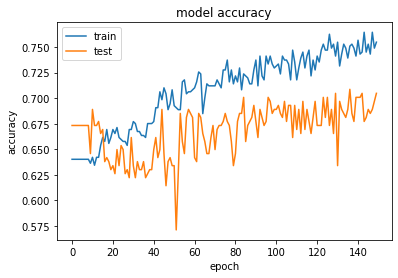

In [9]:
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train' , 'test'], loc = 'upper left' )
plt.show()

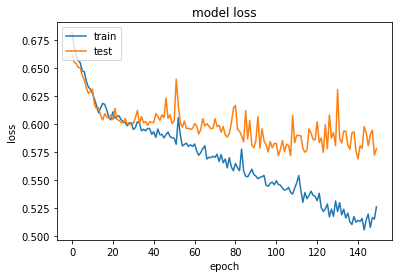

In [10]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train' , 'test'], loc= 'upper left')
plt.show()

## Dropout

In [11]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import tensorflow as tf
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm
from keras.optimizers import SGD
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings('ignore')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

seed = 7
np.random.seed(seed)

In [12]:
dataframe = pd.read_csv("../datasets/sonar.csv", header=None)
dataset = dataframe.values

In [13]:
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [14]:
X = dataset[:,0:60].astype(float)
Y = dataset[:,60]

In [15]:
X[:1]

array([[0.02  , 0.0371, 0.0428, 0.0207, 0.0954, 0.0986, 0.1539, 0.1601,
        0.3109, 0.2111, 0.1609, 0.1582, 0.2238, 0.0645, 0.066 , 0.2273,
        0.31  , 0.2999, 0.5078, 0.4797, 0.5783, 0.5071, 0.4328, 0.555 ,
        0.6711, 0.6415, 0.7104, 0.808 , 0.6791, 0.3857, 0.1307, 0.2604,
        0.5121, 0.7547, 0.8537, 0.8507, 0.6692, 0.6097, 0.4943, 0.2744,
        0.051 , 0.2834, 0.2825, 0.4256, 0.2641, 0.1386, 0.1051, 0.1343,
        0.0383, 0.0324, 0.0232, 0.0027, 0.0065, 0.0159, 0.0072, 0.0167,
        0.018 , 0.0084, 0.009 , 0.0032]])

In [16]:
Y[:10]

array(['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R'], dtype=object)

In [17]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

In [26]:
def create_baseline_model():
    
    # create model
    model = Sequential()
    
    #model.add(Dense(60, input_dim = 60, kernel_initializer = 'normal', activation = 'relu'))
    #model.add(Dense(30, kernel_initializer = 'normal', activation = 'relu'))
    #model.add(Dense(1, kernel_initializer = 'normal', activation = 'sigmoid'))
    
    #model.add(Dropout(0.2, input_shape=(60,)))
    model.add(Dense(60, kernel_initializer  = 'normal', activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(30, kernel_initializer = 'normal', activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer = 'normal', activation = 'sigmoid'))
    
    # Compile model
    #sgd = SGD(lr = 0.01, momentum = 0.8, decay = 0.0, nesterov = False)
    sgd = SGD(lr = 0.1, momentum = 0.9, decay = 0.0, nesterov = False)
    
    model.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])
    #model.compile(loss = 'binary_crossentropy', optimizer = 'adam' , metrics = ['accuracy'])
    
    return model

In [27]:
np.random.seed(seed)

estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn = create_baseline_model, epochs = 300, batch_size = 16, verbose = 0)))

pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = seed)

results = cross_val_score(pipeline, X, encoded_Y, cv = kfold)

print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 60.05% (12.93%)
